In [1]:
# Cell 1 - Install required packages
!pip install torch torchvision albumentations tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# Cell 2 - Import libraries and mount Google Drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the data directory
data_dir = '/content/drive/MyDrive/Colab_Projects/archive/train'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Cell 3 - Define the Dataset class
class LesionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = np.array(image)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        label = self.labels[idx]
        return image, label

In [4]:
# Cell 4 - Define the model
class MobileNetV3Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
        self.model.classifier[-1] = nn.Linear(self.model.classifier[-1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [5]:
# Cell 5 - Set up data loading function
def load_dataset(data_dir):
    image_paths = []
    labels = []

    # Check if directory exists
    if not os.path.exists(data_dir):
        raise ValueError(f"Directory {data_dir} does not exist!")

    # Load benign images (label 0)
    benign_dir = os.path.join(data_dir, 'benign')
    if os.path.exists(benign_dir):
        for img_name in os.listdir(benign_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(benign_dir, img_name))
                labels.append(0)

    # Load malignant images (label 1)
    malignant_dir = os.path.join(data_dir, 'malignant')
    if os.path.exists(malignant_dir):
        for img_name in os.listdir(malignant_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(malignant_dir, img_name))
                labels.append(1)

    print(f"Found {len(image_paths)} images in total")
    print(f"Benign images: {labels.count(0)}")
    print(f"Malignant images: {labels.count(1)}")

    if len(image_paths) == 0:
        raise ValueError(f"No images found in {data_dir}. Please check the path and data structure.")

    return image_paths, labels

In [6]:
# Cell 6 - Set up transformations and parameters
# Set hyperparameters
num_classes = 2  # benign vs malignant
batch_size = 32
num_epochs = 50
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data augmentation and transformation
train_transform = A.Compose([
    A.SmallestMaxSize(max_size=256),
    A.RandomCrop(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.SmallestMaxSize(max_size=256),
    A.CenterCrop(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [7]:
# Cell 7 - Load and prepare the dataset
print("Contents of data directory:")
if os.path.exists(data_dir):
    print(os.listdir(data_dir))
else:
    print(f"Directory {data_dir} does not exist. Please check the path.")

# Load the dataset
image_paths, labels = load_dataset(data_dir)

# Split dataset
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Create datasets
train_dataset = LesionDataset(train_paths, train_labels, train_transform)
val_dataset = LesionDataset(val_paths, val_labels, val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Contents of data directory:
['malignant', 'benign']
Found 2637 images in total
Benign images: 1440
Malignant images: 1197


In [8]:
# Cell 7A - Check Google Drive contents
print("Checking Google Drive contents...")

# Check main directory
main_dir = '/content/drive/MyDrive'
print("\nContents of MyDrive:")
if os.path.exists(main_dir):
    print(os.listdir(main_dir))
else:
    print("Main directory not found!")

# Try to navigate through the path step by step
paths_to_check = [
    '/content/drive/MyDrive/colab_projects',
    '/content/drive/MyDrive/colab_projects/archive',
    '/content/drive/MyDrive/colab_projects/archive/train'
]

for path in paths_to_check:
    print(f"\nChecking {path}:")
    if os.path.exists(path):
        print("Directory exists!")
        print("Contents:", os.listdir(path))
    else:
        print("Directory does not exist!")

Checking Google Drive contents...

Contents of MyDrive:
['Colab Notebooks', 'fabi vs. malte.gsheet', 'Businessplan Word.doc', 'Businessplan Word.gdoc', 'toolrentpräsi.pptx', 'Präsentation Kommunikation (1).pptx', 'Präsentation Kommunikation (2).pptx.gslides', 'Präsentation Kommunikation (1).pptx.gslides', 'Präsentation Kommunikation.pptx', 'Präsentation Kommunikation.pptx.gslides', 'Präsentation Media Management 2.pptx', 'Präsentation Media Management 2.pptx.gslides', 'computer-bild-2016-03-05.pdf', 'Hausarbeit Canvas Model.docx', 'Hausarbeit Canvas Model.docx.gdoc', 'MichaelRolig-GoogleResume.docx', 'MichaelRolig-GoogleResume.docx.gdoc', 'CV Fabian Tewes.gdoc', 'Projektplan-FAT.pptx', 'Projektplan-FAT.pptx.gslides', 'Namensschild.gdoc', 'qlair next steps.gdoc', 'Bewerbung für die Vier-Zimmer-Wohnung im Wohnpark „Am Stadtwald“.gdoc', 'CV Fabian Tewes 02.03.2018.gdoc', 'GraphCMS .gdoc', 'Wohnungsberechnung.gsheet', 'CV Fabian Tewes 17.02.2019.gdoc', 'Untitled spreadsheet (2).gs

In [9]:
# Cell 8 - Training and validation functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': running_loss/total, 'accuracy': 100.*correct/total})

    return running_loss/len(train_loader), 100.*correct/total

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss/len(val_loader), 100.*correct/total

In [10]:
# Cell 9 - Training loop
model = MobileNetV3Classifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

best_val_acc = 0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_model.pth')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 81.1MB/s]



Epoch 1/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.3632 Train Acc: 83.17%
Val Loss: 2.5636 Val Acc: 57.77%

Epoch 2/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.2714 Train Acc: 88.00%
Val Loss: 2.7057 Val Acc: 62.50%

Epoch 3/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.2765 Train Acc: 87.77%
Val Loss: 0.6184 Val Acc: 83.90%

Epoch 4/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.2247 Train Acc: 89.81%
Val Loss: 0.4067 Val Acc: 85.04%

Epoch 5/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.2045 Train Acc: 90.00%
Val Loss: 0.3292 Val Acc: 88.26%

Epoch 6/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.2171 Train Acc: 90.99%
Val Loss: 0.2797 Val Acc: 88.83%

Epoch 7/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.1930 Train Acc: 91.13%
Val Loss: 0.3472 Val Acc: 88.64%

Epoch 8/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.1733 Train Acc: 93.03%
Val Loss: 0.3619 Val Acc: 88.83%

Epoch 9/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.1678 Train Acc: 92.75%
Val Loss: 0.2828 Val Acc: 88.64%

Epoch 10/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.1337 Train Acc: 94.50%
Val Loss: 0.2761 Val Acc: 89.77%

Epoch 11/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.1407 Train Acc: 94.03%
Val Loss: 0.4208 Val Acc: 86.93%

Epoch 12/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.1134 Train Acc: 95.59%
Val Loss: 0.5259 Val Acc: 83.90%

Epoch 13/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.1100 Train Acc: 95.26%
Val Loss: 0.3693 Val Acc: 89.96%

Epoch 14/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.1080 Train Acc: 96.30%
Val Loss: 0.2876 Val Acc: 88.45%

Epoch 15/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.1001 Train Acc: 96.49%
Val Loss: 0.3900 Val Acc: 89.39%

Epoch 16/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.1284 Train Acc: 94.83%
Val Loss: 0.3588 Val Acc: 89.58%

Epoch 17/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0588 Train Acc: 97.96%
Val Loss: 0.3523 Val Acc: 90.15%

Epoch 18/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0512 Train Acc: 98.10%
Val Loss: 0.3277 Val Acc: 90.34%

Epoch 19/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0340 Train Acc: 99.00%
Val Loss: 0.3355 Val Acc: 90.53%

Epoch 20/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0315 Train Acc: 98.91%
Val Loss: 0.3514 Val Acc: 89.96%

Epoch 21/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0361 Train Acc: 98.34%
Val Loss: 0.3530 Val Acc: 90.34%

Epoch 22/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0311 Train Acc: 98.77%
Val Loss: 0.3898 Val Acc: 90.72%

Epoch 23/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0265 Train Acc: 99.05%
Val Loss: 0.3830 Val Acc: 90.72%

Epoch 24/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0283 Train Acc: 98.91%
Val Loss: 0.3687 Val Acc: 90.53%

Epoch 25/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0240 Train Acc: 99.10%
Val Loss: 0.3681 Val Acc: 90.34%

Epoch 26/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0164 Train Acc: 99.43%
Val Loss: 0.3713 Val Acc: 90.34%

Epoch 27/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0178 Train Acc: 99.24%
Val Loss: 0.3713 Val Acc: 90.53%

Epoch 28/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0188 Train Acc: 99.19%
Val Loss: 0.3798 Val Acc: 90.53%

Epoch 29/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0223 Train Acc: 99.10%
Val Loss: 0.3833 Val Acc: 90.72%

Epoch 30/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0227 Train Acc: 99.24%
Val Loss: 0.3853 Val Acc: 90.72%

Epoch 31/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0281 Train Acc: 99.15%
Val Loss: 0.3840 Val Acc: 90.53%

Epoch 32/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0150 Train Acc: 99.62%
Val Loss: 0.3855 Val Acc: 90.72%

Epoch 33/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0176 Train Acc: 99.38%
Val Loss: 0.3847 Val Acc: 90.72%

Epoch 34/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0291 Train Acc: 99.34%
Val Loss: 0.3832 Val Acc: 90.91%

Epoch 35/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0193 Train Acc: 99.19%
Val Loss: 0.3855 Val Acc: 90.72%

Epoch 36/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0209 Train Acc: 99.29%
Val Loss: 0.3842 Val Acc: 90.72%

Epoch 37/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0209 Train Acc: 99.34%
Val Loss: 0.3833 Val Acc: 90.72%

Epoch 38/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0139 Train Acc: 99.57%
Val Loss: 0.3800 Val Acc: 90.72%

Epoch 39/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0234 Train Acc: 99.05%
Val Loss: 0.3806 Val Acc: 90.72%

Epoch 40/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0206 Train Acc: 99.19%
Val Loss: 0.3841 Val Acc: 90.72%

Epoch 41/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0280 Train Acc: 98.86%
Val Loss: 0.3834 Val Acc: 90.72%

Epoch 42/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0176 Train Acc: 99.48%
Val Loss: 0.3822 Val Acc: 90.72%

Epoch 43/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0292 Train Acc: 99.00%
Val Loss: 0.3836 Val Acc: 90.72%

Epoch 44/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0185 Train Acc: 99.43%
Val Loss: 0.3822 Val Acc: 90.72%

Epoch 45/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0214 Train Acc: 99.19%
Val Loss: 0.3834 Val Acc: 90.72%

Epoch 46/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0233 Train Acc: 99.15%
Val Loss: 0.3813 Val Acc: 90.53%

Epoch 47/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0175 Train Acc: 99.48%
Val Loss: 0.3831 Val Acc: 90.72%

Epoch 48/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0228 Train Acc: 99.15%
Val Loss: 0.3831 Val Acc: 90.72%

Epoch 49/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0228 Train Acc: 99.24%
Val Loss: 0.3827 Val Acc: 90.72%

Epoch 50/50


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Train Loss: 0.0235 Train Acc: 99.15%
Val Loss: 0.3827 Val Acc: 90.72%


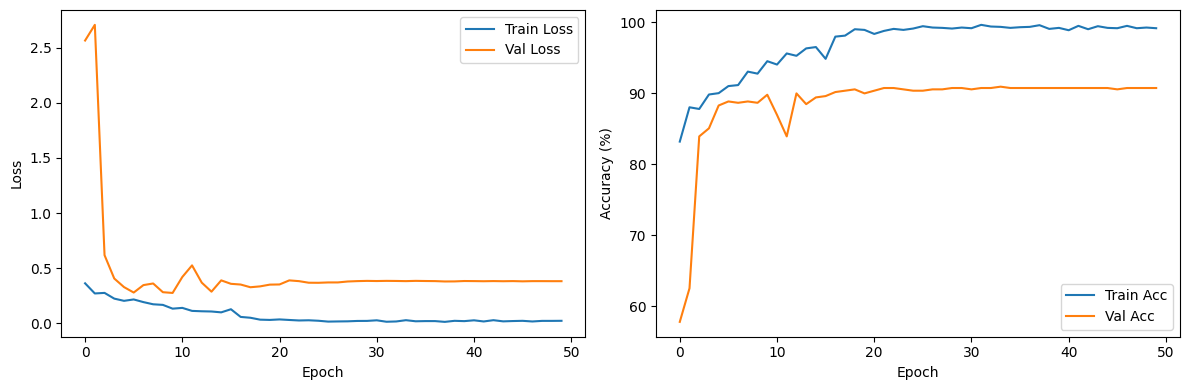

In [11]:
# Cell 10 - Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/training_history.png')
plt.show()

Testing

In [12]:
# Cell 1 - Test Dataset Evaluation
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Make sure we're using the same device as training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Cell 2 - Define the dataset class (same as training)
class LesionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = np.array(image)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        label = self.labels[idx]
        return image, label

In [14]:
# Cell 3 - Define the model (same as training)
class MobileNetV3Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
        self.model.classifier[-1] = nn.Linear(self.model.classifier[-1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [15]:
# Cell 4 - Load test data
def load_test_dataset(data_dir):
    image_paths = []
    labels = []

    # Load benign images (label 0)
    benign_dir = os.path.join(data_dir, 'benign')
    if os.path.exists(benign_dir):
        for img_name in os.listdir(benign_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(benign_dir, img_name))
                labels.append(0)

    # Load malignant images (label 1)
    malignant_dir = os.path.join(data_dir, 'malignant')
    if os.path.exists(malignant_dir):
        for img_name in os.listdir(malignant_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(malignant_dir, img_name))
                labels.append(1)

    print(f"Found {len(image_paths)} test images in total")
    print(f"Benign images: {labels.count(0)}")
    print(f"Malignant images: {labels.count(1)}")

    return image_paths, labels

# Set up test data transforms (no augmentation for test data)
test_transform = A.Compose([
    A.SmallestMaxSize(max_size=256),
    A.CenterCrop(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Load test dataset
test_dir = '/content/drive/MyDrive/Colab_Projects/archive/test'
test_paths, test_labels = load_test_dataset(test_dir)

# Create test dataset and dataloader
test_dataset = LesionDataset(test_paths, test_labels, test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Found 660 test images in total
Benign images: 360
Malignant images: 300


In [16]:
# Cell 5 - Load the trained model
# Make sure to update this path to where your best model is saved
model_path = '/content/drive/MyDrive/best_model.pth'

# Initialize model and load weights
model = MobileNetV3Classifier(num_classes=2).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

MobileNetV3Classifier(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormA

Testing:   0%|          | 0/21 [00:00<?, ?it/s]


Test Accuracy: 91.36%

Classification Report:
              precision    recall  f1-score   support

      Benign       0.93      0.91      0.92       360
   Malignant       0.90      0.92      0.91       300

    accuracy                           0.91       660
   macro avg       0.91      0.91      0.91       660
weighted avg       0.91      0.91      0.91       660



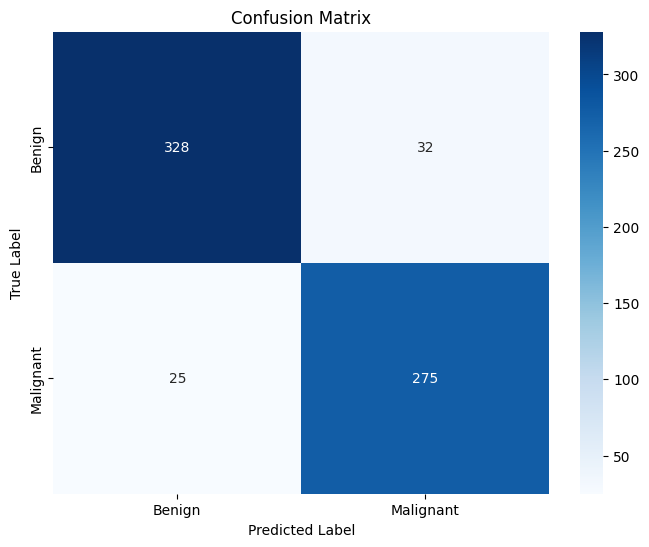

In [17]:
# Cell 6 - Evaluate on test set
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total
    return accuracy, all_preds, all_labels

# Evaluate the model
test_accuracy, predictions, true_labels = evaluate_model(model, test_loader, device)
print(f'\nTest Accuracy: {test_accuracy:.2f}%')

# Print detailed classification report
print('\nClassification Report:')
print(classification_report(true_labels, predictions,
                          target_names=['Benign', 'Malignant']))

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('/content/drive/MyDrive/confusion_matrix.png')
plt.show()

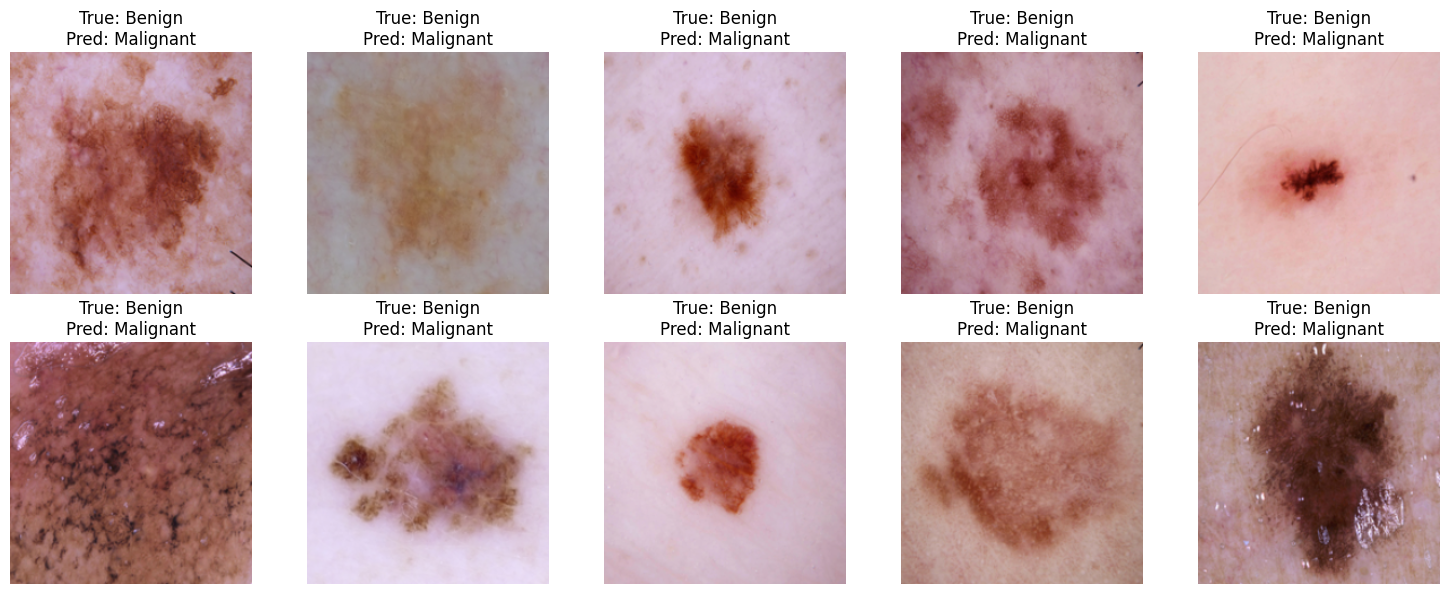

In [18]:
# Cell 7 - Analyze incorrect predictions
def show_incorrect_predictions(model, test_loader, device, num_images=10):
    model.eval()
    incorrect_images = []
    incorrect_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)

            # Find incorrect predictions
            incorrect_mask = ~predicted.eq(labels)
            if incorrect_mask.any():
                incorrect_imgs = images[incorrect_mask]
                true_labs = labels[incorrect_mask]
                pred_labs = predicted[incorrect_mask]

                for img, true_lab, pred_lab in zip(incorrect_imgs, true_labs, pred_labs):
                    incorrect_images.append(img.cpu())
                    incorrect_labels.append(true_lab.item())
                    predicted_labels.append(pred_lab.item())

                    if len(incorrect_images) >= num_images:
                        break

            if len(incorrect_images) >= num_images:
                break

    # Plot incorrect predictions
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for idx, (img, true_lab, pred_lab) in enumerate(zip(incorrect_images[:num_images],
                                                       incorrect_labels[:num_images],
                                                       predicted_labels[:num_images])):
        img = img.permute(1, 2, 0).numpy()
        img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)

        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'True: {"Malignant" if true_lab else "Benign"}\n'
                           f'Pred: {"Malignant" if pred_lab else "Benign"}')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/incorrect_predictions.png')
    plt.show()

# Show some incorrect predictions
show_incorrect_predictions(model, test_loader, device)

In [19]:
# CELL 1 - Import required libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from tqdm.notebook import tqdm
import os

In [20]:
# CELL 2 - Define the model
class EnhancedModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Load pretrained EfficientNet
        self.effnet = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)

        # Modify classifier with dropout
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(1536, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )
        self.effnet.classifier = self.classifier

    def forward(self, x):
        return self.effnet(x)

In [21]:
# CELL 3 - Dataset class
class LesionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = np.array(image)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, self.labels[idx], self.image_paths[idx]

In [22]:
# CELL 4 - Function to load test dataset
def load_test_dataset(data_dir):
    image_paths = []
    labels = []

    # Load benign images (label 0)
    benign_dir = os.path.join(data_dir, 'benign')
    if os.path.exists(benign_dir):
        for img_name in os.listdir(benign_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(benign_dir, img_name))
                labels.append(0)

    # Load malignant images (label 1)
    malignant_dir = os.path.join(data_dir, 'malignant')
    if os.path.exists(malignant_dir):
        for img_name in os.listdir(malignant_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(malignant_dir, img_name))
                labels.append(1)

    print(f"Found {len(image_paths)} test images in total")
    print(f"Benign images: {labels.count(0)}")
    print(f"Malignant images: {labels.count(1)}")

    return image_paths, labels

In [23]:
# CELL 5 - Function to display false negatives
def display_false_negatives(model, test_loader, device, num_images=10):
    model.eval()
    false_negatives = []
    file_names = []
    confidences = []

    with torch.no_grad():
        for images, labels, paths in tqdm(test_loader, desc='Finding false negatives'):
            images = images.to(device)
            labels = labels.to(device)

            # Get model predictions
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            # Find false negatives (malignant classified as benign)
            mask = (labels == 1) & (predicted == 0)

            if mask.any():
                false_neg_images = images[mask]
                false_neg_probs = probabilities[mask]
                false_neg_paths = [paths[i] for i, m in enumerate(mask) if m]

                for img, prob, path in zip(false_neg_images, false_neg_probs, false_neg_paths):
                    false_negatives.append(img.cpu())
                    file_names.append(os.path.basename(path))
                    confidences.append(prob[0].item())  # probability of benign class

                    if len(false_negatives) >= num_images:
                        break

            if len(false_negatives) >= num_images:
                break

    if not false_negatives:
        print("No false negatives found in the test set!")
        return

    # Calculate number of rows and columns for the plot
    n_cols = min(5, num_images)
    n_rows = (len(false_negatives) + n_cols - 1) // n_cols

    # Create figure
    plt.figure(figsize=(4*n_cols, 4*n_rows))

    for idx, (img, fname, conf) in enumerate(zip(false_negatives, file_names, confidences)):
        plt.subplot(n_rows, n_cols, idx + 1)

        # Convert tensor to image
        img = img.permute(1, 2, 0).numpy()
        # Denormalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.axis('off')
        plt.title(f'File: {fname}\nConf(Benign): {conf:.2%}', fontsize=8)

    plt.tight_layout()
    plt.suptitle('False Negatives: Malignant Lesions Classified as Benign', y=1.02)
    plt.savefig('/content/drive/MyDrive/false_negatives.png', bbox_inches='tight', dpi=300)
    plt.show()

    # Print summary statistics
    print(f"\nFound {len(false_negatives)} false negatives")
    print("\nConfidence Statistics for Benign Predictions (on Malignant Cases):")
    print(f"Mean confidence: {np.mean(confidences):.2%}")
    print(f"Min confidence: {np.min(confidences):.2%}")
    print(f"Max confidence: {np.max(confidences):.2%}")

In [24]:
# CELL 6 - Set up device and transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [25]:
# CELL 7 - Load and prepare test data
test_dir = '/content/drive/MyDrive/Colab_Projects/archive/test'
test_paths, test_labels = load_test_dataset(test_dir)
test_dataset = LesionDataset(test_paths, test_labels, test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Found 660 test images in total
Benign images: 360
Malignant images: 300


In [26]:
# CELL 8 - Load model and display false negatives
model_path = '/content/drive/MyDrive/best_model.pth'
model = EnhancedModel().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Display false negatives
display_false_negatives(model, test_loader, device, num_images=15)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 107MB/s]


RuntimeError: Error(s) in loading state_dict for EnhancedModel:
	Missing key(s) in state_dict: "effnet.features.0.0.weight", "effnet.features.0.1.weight", "effnet.features.0.1.bias", "effnet.features.0.1.running_mean", "effnet.features.0.1.running_var", "effnet.features.1.0.block.0.0.weight", "effnet.features.1.0.block.0.1.weight", "effnet.features.1.0.block.0.1.bias", "effnet.features.1.0.block.0.1.running_mean", "effnet.features.1.0.block.0.1.running_var", "effnet.features.1.0.block.1.fc1.weight", "effnet.features.1.0.block.1.fc1.bias", "effnet.features.1.0.block.1.fc2.weight", "effnet.features.1.0.block.1.fc2.bias", "effnet.features.1.0.block.2.0.weight", "effnet.features.1.0.block.2.1.weight", "effnet.features.1.0.block.2.1.bias", "effnet.features.1.0.block.2.1.running_mean", "effnet.features.1.0.block.2.1.running_var", "effnet.features.1.1.block.0.0.weight", "effnet.features.1.1.block.0.1.weight", "effnet.features.1.1.block.0.1.bias", "effnet.features.1.1.block.0.1.running_mean", "effnet.features.1.1.block.0.1.running_var", "effnet.features.1.1.block.1.fc1.weight", "effnet.features.1.1.block.1.fc1.bias", "effnet.features.1.1.block.1.fc2.weight", "effnet.features.1.1.block.1.fc2.bias", "effnet.features.1.1.block.2.0.weight", "effnet.features.1.1.block.2.1.weight", "effnet.features.1.1.block.2.1.bias", "effnet.features.1.1.block.2.1.running_mean", "effnet.features.1.1.block.2.1.running_var", "effnet.features.2.0.block.0.0.weight", "effnet.features.2.0.block.0.1.weight", "effnet.features.2.0.block.0.1.bias", "effnet.features.2.0.block.0.1.running_mean", "effnet.features.2.0.block.0.1.running_var", "effnet.features.2.0.block.1.0.weight", "effnet.features.2.0.block.1.1.weight", "effnet.features.2.0.block.1.1.bias", "effnet.features.2.0.block.1.1.running_mean", "effnet.features.2.0.block.1.1.running_var", "effnet.features.2.0.block.2.fc1.weight", "effnet.features.2.0.block.2.fc1.bias", "effnet.features.2.0.block.2.fc2.weight", "effnet.features.2.0.block.2.fc2.bias", "effnet.features.2.0.block.3.0.weight", "effnet.features.2.0.block.3.1.weight", "effnet.features.2.0.block.3.1.bias", "effnet.features.2.0.block.3.1.running_mean", "effnet.features.2.0.block.3.1.running_var", "effnet.features.2.1.block.0.0.weight", "effnet.features.2.1.block.0.1.weight", "effnet.features.2.1.block.0.1.bias", "effnet.features.2.1.block.0.1.running_mean", "effnet.features.2.1.block.0.1.running_var", "effnet.features.2.1.block.1.0.weight", "effnet.features.2.1.block.1.1.weight", "effnet.features.2.1.block.1.1.bias", "effnet.features.2.1.block.1.1.running_mean", "effnet.features.2.1.block.1.1.running_var", "effnet.features.2.1.block.2.fc1.weight", "effnet.features.2.1.block.2.fc1.bias", "effnet.features.2.1.block.2.fc2.weight", "effnet.features.2.1.block.2.fc2.bias", "effnet.features.2.1.block.3.0.weight", "effnet.features.2.1.block.3.1.weight", "effnet.features.2.1.block.3.1.bias", "effnet.features.2.1.block.3.1.running_mean", "effnet.features.2.1.block.3.1.running_var", "effnet.features.2.2.block.0.0.weight", "effnet.features.2.2.block.0.1.weight", "effnet.features.2.2.block.0.1.bias", "effnet.features.2.2.block.0.1.running_mean", "effnet.features.2.2.block.0.1.running_var", "effnet.features.2.2.block.1.0.weight", "effnet.features.2.2.block.1.1.weight", "effnet.features.2.2.block.1.1.bias", "effnet.features.2.2.block.1.1.running_mean", "effnet.features.2.2.block.1.1.running_var", "effnet.features.2.2.block.2.fc1.weight", "effnet.features.2.2.block.2.fc1.bias", "effnet.features.2.2.block.2.fc2.weight", "effnet.features.2.2.block.2.fc2.bias", "effnet.features.2.2.block.3.0.weight", "effnet.features.2.2.block.3.1.weight", "effnet.features.2.2.block.3.1.bias", "effnet.features.2.2.block.3.1.running_mean", "effnet.features.2.2.block.3.1.running_var", "effnet.features.3.0.block.0.0.weight", "effnet.features.3.0.block.0.1.weight", "effnet.features.3.0.block.0.1.bias", "effnet.features.3.0.block.0.1.running_mean", "effnet.features.3.0.block.0.1.running_var", "effnet.features.3.0.block.1.0.weight", "effnet.features.3.0.block.1.1.weight", "effnet.features.3.0.block.1.1.bias", "effnet.features.3.0.block.1.1.running_mean", "effnet.features.3.0.block.1.1.running_var", "effnet.features.3.0.block.2.fc1.weight", "effnet.features.3.0.block.2.fc1.bias", "effnet.features.3.0.block.2.fc2.weight", "effnet.features.3.0.block.2.fc2.bias", "effnet.features.3.0.block.3.0.weight", "effnet.features.3.0.block.3.1.weight", "effnet.features.3.0.block.3.1.bias", "effnet.features.3.0.block.3.1.running_mean", "effnet.features.3.0.block.3.1.running_var", "effnet.features.3.1.block.0.0.weight", "effnet.features.3.1.block.0.1.weight", "effnet.features.3.1.block.0.1.bias", "effnet.features.3.1.block.0.1.running_mean", "effnet.features.3.1.block.0.1.running_var", "effnet.features.3.1.block.1.0.weight", "effnet.features.3.1.block.1.1.weight", "effnet.features.3.1.block.1.1.bias", "effnet.features.3.1.block.1.1.running_mean", "effnet.features.3.1.block.1.1.running_var", "effnet.features.3.1.block.2.fc1.weight", "effnet.features.3.1.block.2.fc1.bias", "effnet.features.3.1.block.2.fc2.weight", "effnet.features.3.1.block.2.fc2.bias", "effnet.features.3.1.block.3.0.weight", "effnet.features.3.1.block.3.1.weight", "effnet.features.3.1.block.3.1.bias", "effnet.features.3.1.block.3.1.running_mean", "effnet.features.3.1.block.3.1.running_var", "effnet.features.3.2.block.0.0.weight", "effnet.features.3.2.block.0.1.weight", "effnet.features.3.2.block.0.1.bias", "effnet.features.3.2.block.0.1.running_mean", "effnet.features.3.2.block.0.1.running_var", "effnet.features.3.2.block.1.0.weight", "effnet.features.3.2.block.1.1.weight", "effnet.features.3.2.block.1.1.bias", "effnet.features.3.2.block.1.1.running_mean", "effnet.features.3.2.block.1.1.running_var", "effnet.features.3.2.block.2.fc1.weight", "effnet.features.3.2.block.2.fc1.bias", "effnet.features.3.2.block.2.fc2.weight", "effnet.features.3.2.block.2.fc2.bias", "effnet.features.3.2.block.3.0.weight", "effnet.features.3.2.block.3.1.weight", "effnet.features.3.2.block.3.1.bias", "effnet.features.3.2.block.3.1.running_mean", "effnet.features.3.2.block.3.1.running_var", "effnet.features.4.0.block.0.0.weight", "effnet.features.4.0.block.0.1.weight", "effnet.features.4.0.block.0.1.bias", "effnet.features.4.0.block.0.1.running_mean", "effnet.features.4.0.block.0.1.running_var", "effnet.features.4.0.block.1.0.weight", "effnet.features.4.0.block.1.1.weight", "effnet.features.4.0.block.1.1.bias", "effnet.features.4.0.block.1.1.running_mean", "effnet.features.4.0.block.1.1.running_var", "effnet.features.4.0.block.2.fc1.weight", "effnet.features.4.0.block.2.fc1.bias", "effnet.features.4.0.block.2.fc2.weight", "effnet.features.4.0.block.2.fc2.bias", "effnet.features.4.0.block.3.0.weight", "effnet.features.4.0.block.3.1.weight", "effnet.features.4.0.block.3.1.bias", "effnet.features.4.0.block.3.1.running_mean", "effnet.features.4.0.block.3.1.running_var", "effnet.features.4.1.block.0.0.weight", "effnet.features.4.1.block.0.1.weight", "effnet.features.4.1.block.0.1.bias", "effnet.features.4.1.block.0.1.running_mean", "effnet.features.4.1.block.0.1.running_var", "effnet.features.4.1.block.1.0.weight", "effnet.features.4.1.block.1.1.weight", "effnet.features.4.1.block.1.1.bias", "effnet.features.4.1.block.1.1.running_mean", "effnet.features.4.1.block.1.1.running_var", "effnet.features.4.1.block.2.fc1.weight", "effnet.features.4.1.block.2.fc1.bias", "effnet.features.4.1.block.2.fc2.weight", "effnet.features.4.1.block.2.fc2.bias", "effnet.features.4.1.block.3.0.weight", "effnet.features.4.1.block.3.1.weight", "effnet.features.4.1.block.3.1.bias", "effnet.features.4.1.block.3.1.running_mean", "effnet.features.4.1.block.3.1.running_var", "effnet.features.4.2.block.0.0.weight", "effnet.features.4.2.block.0.1.weight", "effnet.features.4.2.block.0.1.bias", "effnet.features.4.2.block.0.1.running_mean", "effnet.features.4.2.block.0.1.running_var", "effnet.features.4.2.block.1.0.weight", "effnet.features.4.2.block.1.1.weight", "effnet.features.4.2.block.1.1.bias", "effnet.features.4.2.block.1.1.running_mean", "effnet.features.4.2.block.1.1.running_var", "effnet.features.4.2.block.2.fc1.weight", "effnet.features.4.2.block.2.fc1.bias", "effnet.features.4.2.block.2.fc2.weight", "effnet.features.4.2.block.2.fc2.bias", "effnet.features.4.2.block.3.0.weight", "effnet.features.4.2.block.3.1.weight", "effnet.features.4.2.block.3.1.bias", "effnet.features.4.2.block.3.1.running_mean", "effnet.features.4.2.block.3.1.running_var", "effnet.features.4.3.block.0.0.weight", "effnet.features.4.3.block.0.1.weight", "effnet.features.4.3.block.0.1.bias", "effnet.features.4.3.block.0.1.running_mean", "effnet.features.4.3.block.0.1.running_var", "effnet.features.4.3.block.1.0.weight", "effnet.features.4.3.block.1.1.weight", "effnet.features.4.3.block.1.1.bias", "effnet.features.4.3.block.1.1.running_mean", "effnet.features.4.3.block.1.1.running_var", "effnet.features.4.3.block.2.fc1.weight", "effnet.features.4.3.block.2.fc1.bias", "effnet.features.4.3.block.2.fc2.weight", "effnet.features.4.3.block.2.fc2.bias", "effnet.features.4.3.block.3.0.weight", "effnet.features.4.3.block.3.1.weight", "effnet.features.4.3.block.3.1.bias", "effnet.features.4.3.block.3.1.running_mean", "effnet.features.4.3.block.3.1.running_var", "effnet.features.4.4.block.0.0.weight", "effnet.features.4.4.block.0.1.weight", "effnet.features.4.4.block.0.1.bias", "effnet.features.4.4.block.0.1.running_mean", "effnet.features.4.4.block.0.1.running_var", "effnet.features.4.4.block.1.0.weight", "effnet.features.4.4.block.1.1.weight", "effnet.features.4.4.block.1.1.bias", "effnet.features.4.4.block.1.1.running_mean", "effnet.features.4.4.block.1.1.running_var", "effnet.features.4.4.block.2.fc1.weight", "effnet.features.4.4.block.2.fc1.bias", "effnet.features.4.4.block.2.fc2.weight", "effnet.features.4.4.block.2.fc2.bias", "effnet.features.4.4.block.3.0.weight", "effnet.features.4.4.block.3.1.weight", "effnet.features.4.4.block.3.1.bias", "effnet.features.4.4.block.3.1.running_mean", "effnet.features.4.4.block.3.1.running_var", "effnet.features.5.0.block.0.0.weight", "effnet.features.5.0.block.0.1.weight", "effnet.features.5.0.block.0.1.bias", "effnet.features.5.0.block.0.1.running_mean", "effnet.features.5.0.block.0.1.running_var", "effnet.features.5.0.block.1.0.weight", "effnet.features.5.0.block.1.1.weight", "effnet.features.5.0.block.1.1.bias", "effnet.features.5.0.block.1.1.running_mean", "effnet.features.5.0.block.1.1.running_var", "effnet.features.5.0.block.2.fc1.weight", "effnet.features.5.0.block.2.fc1.bias", "effnet.features.5.0.block.2.fc2.weight", "effnet.features.5.0.block.2.fc2.bias", "effnet.features.5.0.block.3.0.weight", "effnet.features.5.0.block.3.1.weight", "effnet.features.5.0.block.3.1.bias", "effnet.features.5.0.block.3.1.running_mean", "effnet.features.5.0.block.3.1.running_var", "effnet.features.5.1.block.0.0.weight", "effnet.features.5.1.block.0.1.weight", "effnet.features.5.1.block.0.1.bias", "effnet.features.5.1.block.0.1.running_mean", "effnet.features.5.1.block.0.1.running_var", "effnet.features.5.1.block.1.0.weight", "effnet.features.5.1.block.1.1.weight", "effnet.features.5.1.block.1.1.bias", "effnet.features.5.1.block.1.1.running_mean", "effnet.features.5.1.block.1.1.running_var", "effnet.features.5.1.block.2.fc1.weight", "effnet.features.5.1.block.2.fc1.bias", "effnet.features.5.1.block.2.fc2.weight", "effnet.features.5.1.block.2.fc2.bias", "effnet.features.5.1.block.3.0.weight", "effnet.features.5.1.block.3.1.weight", "effnet.features.5.1.block.3.1.bias", "effnet.features.5.1.block.3.1.running_mean", "effnet.features.5.1.block.3.1.running_var", "effnet.features.5.2.block.0.0.weight", "effnet.features.5.2.block.0.1.weight", "effnet.features.5.2.block.0.1.bias", "effnet.features.5.2.block.0.1.running_mean", "effnet.features.5.2.block.0.1.running_var", "effnet.features.5.2.block.1.0.weight", "effnet.features.5.2.block.1.1.weight", "effnet.features.5.2.block.1.1.bias", "effnet.features.5.2.block.1.1.running_mean", "effnet.features.5.2.block.1.1.running_var", "effnet.features.5.2.block.2.fc1.weight", "effnet.features.5.2.block.2.fc1.bias", "effnet.features.5.2.block.2.fc2.weight", "effnet.features.5.2.block.2.fc2.bias", "effnet.features.5.2.block.3.0.weight", "effnet.features.5.2.block.3.1.weight", "effnet.features.5.2.block.3.1.bias", "effnet.features.5.2.block.3.1.running_mean", "effnet.features.5.2.block.3.1.running_var", "effnet.features.5.3.block.0.0.weight", "effnet.features.5.3.block.0.1.weight", "effnet.features.5.3.block.0.1.bias", "effnet.features.5.3.block.0.1.running_mean", "effnet.features.5.3.block.0.1.running_var", "effnet.features.5.3.block.1.0.weight", "effnet.features.5.3.block.1.1.weight", "effnet.features.5.3.block.1.1.bias", "effnet.features.5.3.block.1.1.running_mean", "effnet.features.5.3.block.1.1.running_var", "effnet.features.5.3.block.2.fc1.weight", "effnet.features.5.3.block.2.fc1.bias", "effnet.features.5.3.block.2.fc2.weight", "effnet.features.5.3.block.2.fc2.bias", "effnet.features.5.3.block.3.0.weight", "effnet.features.5.3.block.3.1.weight", "effnet.features.5.3.block.3.1.bias", "effnet.features.5.3.block.3.1.running_mean", "effnet.features.5.3.block.3.1.running_var", "effnet.features.5.4.block.0.0.weight", "effnet.features.5.4.block.0.1.weight", "effnet.features.5.4.block.0.1.bias", "effnet.features.5.4.block.0.1.running_mean", "effnet.features.5.4.block.0.1.running_var", "effnet.features.5.4.block.1.0.weight", "effnet.features.5.4.block.1.1.weight", "effnet.features.5.4.block.1.1.bias", "effnet.features.5.4.block.1.1.running_mean", "effnet.features.5.4.block.1.1.running_var", "effnet.features.5.4.block.2.fc1.weight", "effnet.features.5.4.block.2.fc1.bias", "effnet.features.5.4.block.2.fc2.weight", "effnet.features.5.4.block.2.fc2.bias", "effnet.features.5.4.block.3.0.weight", "effnet.features.5.4.block.3.1.weight", "effnet.features.5.4.block.3.1.bias", "effnet.features.5.4.block.3.1.running_mean", "effnet.features.5.4.block.3.1.running_var", "effnet.features.6.0.block.0.0.weight", "effnet.features.6.0.block.0.1.weight", "effnet.features.6.0.block.0.1.bias", "effnet.features.6.0.block.0.1.running_mean", "effnet.features.6.0.block.0.1.running_var", "effnet.features.6.0.block.1.0.weight", "effnet.features.6.0.block.1.1.weight", "effnet.features.6.0.block.1.1.bias", "effnet.features.6.0.block.1.1.running_mean", "effnet.features.6.0.block.1.1.running_var", "effnet.features.6.0.block.2.fc1.weight", "effnet.features.6.0.block.2.fc1.bias", "effnet.features.6.0.block.2.fc2.weight", "effnet.features.6.0.block.2.fc2.bias", "effnet.features.6.0.block.3.0.weight", "effnet.features.6.0.block.3.1.weight", "effnet.features.6.0.block.3.1.bias", "effnet.features.6.0.block.3.1.running_mean", "effnet.features.6.0.block.3.1.running_var", "effnet.features.6.1.block.0.0.weight", "effnet.features.6.1.block.0.1.weight", "effnet.features.6.1.block.0.1.bias", "effnet.features.6.1.block.0.1.running_mean", "effnet.features.6.1.block.0.1.running_var", "effnet.features.6.1.block.1.0.weight", "effnet.features.6.1.block.1.1.weight", "effnet.features.6.1.block.1.1.bias", "effnet.features.6.1.block.1.1.running_mean", "effnet.features.6.1.block.1.1.running_var", "effnet.features.6.1.block.2.fc1.weight", "effnet.features.6.1.block.2.fc1.bias", "effnet.features.6.1.block.2.fc2.weight", "effnet.features.6.1.block.2.fc2.bias", "effnet.features.6.1.block.3.0.weight", "effnet.features.6.1.block.3.1.weight", "effnet.features.6.1.block.3.1.bias", "effnet.features.6.1.block.3.1.running_mean", "effnet.features.6.1.block.3.1.running_var", "effnet.features.6.2.block.0.0.weight", "effnet.features.6.2.block.0.1.weight", "effnet.features.6.2.block.0.1.bias", "effnet.features.6.2.block.0.1.running_mean", "effnet.features.6.2.block.0.1.running_var", "effnet.features.6.2.block.1.0.weight", "effnet.features.6.2.block.1.1.weight", "effnet.features.6.2.block.1.1.bias", "effnet.features.6.2.block.1.1.running_mean", "effnet.features.6.2.block.1.1.running_var", "effnet.features.6.2.block.2.fc1.weight", "effnet.features.6.2.block.2.fc1.bias", "effnet.features.6.2.block.2.fc2.weight", "effnet.features.6.2.block.2.fc2.bias", "effnet.features.6.2.block.3.0.weight", "effnet.features.6.2.block.3.1.weight", "effnet.features.6.2.block.3.1.bias", "effnet.features.6.2.block.3.1.running_mean", "effnet.features.6.2.block.3.1.running_var", "effnet.features.6.3.block.0.0.weight", "effnet.features.6.3.block.0.1.weight", "effnet.features.6.3.block.0.1.bias", "effnet.features.6.3.block.0.1.running_mean", "effnet.features.6.3.block.0.1.running_var", "effnet.features.6.3.block.1.0.weight", "effnet.features.6.3.block.1.1.weight", "effnet.features.6.3.block.1.1.bias", "effnet.features.6.3.block.1.1.running_mean", "effnet.features.6.3.block.1.1.running_var", "effnet.features.6.3.block.2.fc1.weight", "effnet.features.6.3.block.2.fc1.bias", "effnet.features.6.3.block.2.fc2.weight", "effnet.features.6.3.block.2.fc2.bias", "effnet.features.6.3.block.3.0.weight", "effnet.features.6.3.block.3.1.weight", "effnet.features.6.3.block.3.1.bias", "effnet.features.6.3.block.3.1.running_mean", "effnet.features.6.3.block.3.1.running_var", "effnet.features.6.4.block.0.0.weight", "effnet.features.6.4.block.0.1.weight", "effnet.features.6.4.block.0.1.bias", "effnet.features.6.4.block.0.1.running_mean", "effnet.features.6.4.block.0.1.running_var", "effnet.features.6.4.block.1.0.weight", "effnet.features.6.4.block.1.1.weight", "effnet.features.6.4.block.1.1.bias", "effnet.features.6.4.block.1.1.running_mean", "effnet.features.6.4.block.1.1.running_var", "effnet.features.6.4.block.2.fc1.weight", "effnet.features.6.4.block.2.fc1.bias", "effnet.features.6.4.block.2.fc2.weight", "effnet.features.6.4.block.2.fc2.bias", "effnet.features.6.4.block.3.0.weight", "effnet.features.6.4.block.3.1.weight", "effnet.features.6.4.block.3.1.bias", "effnet.features.6.4.block.3.1.running_mean", "effnet.features.6.4.block.3.1.running_var", "effnet.features.6.5.block.0.0.weight", "effnet.features.6.5.block.0.1.weight", "effnet.features.6.5.block.0.1.bias", "effnet.features.6.5.block.0.1.running_mean", "effnet.features.6.5.block.0.1.running_var", "effnet.features.6.5.block.1.0.weight", "effnet.features.6.5.block.1.1.weight", "effnet.features.6.5.block.1.1.bias", "effnet.features.6.5.block.1.1.running_mean", "effnet.features.6.5.block.1.1.running_var", "effnet.features.6.5.block.2.fc1.weight", "effnet.features.6.5.block.2.fc1.bias", "effnet.features.6.5.block.2.fc2.weight", "effnet.features.6.5.block.2.fc2.bias", "effnet.features.6.5.block.3.0.weight", "effnet.features.6.5.block.3.1.weight", "effnet.features.6.5.block.3.1.bias", "effnet.features.6.5.block.3.1.running_mean", "effnet.features.6.5.block.3.1.running_var", "effnet.features.7.0.block.0.0.weight", "effnet.features.7.0.block.0.1.weight", "effnet.features.7.0.block.0.1.bias", "effnet.features.7.0.block.0.1.running_mean", "effnet.features.7.0.block.0.1.running_var", "effnet.features.7.0.block.1.0.weight", "effnet.features.7.0.block.1.1.weight", "effnet.features.7.0.block.1.1.bias", "effnet.features.7.0.block.1.1.running_mean", "effnet.features.7.0.block.1.1.running_var", "effnet.features.7.0.block.2.fc1.weight", "effnet.features.7.0.block.2.fc1.bias", "effnet.features.7.0.block.2.fc2.weight", "effnet.features.7.0.block.2.fc2.bias", "effnet.features.7.0.block.3.0.weight", "effnet.features.7.0.block.3.1.weight", "effnet.features.7.0.block.3.1.bias", "effnet.features.7.0.block.3.1.running_mean", "effnet.features.7.0.block.3.1.running_var", "effnet.features.7.1.block.0.0.weight", "effnet.features.7.1.block.0.1.weight", "effnet.features.7.1.block.0.1.bias", "effnet.features.7.1.block.0.1.running_mean", "effnet.features.7.1.block.0.1.running_var", "effnet.features.7.1.block.1.0.weight", "effnet.features.7.1.block.1.1.weight", "effnet.features.7.1.block.1.1.bias", "effnet.features.7.1.block.1.1.running_mean", "effnet.features.7.1.block.1.1.running_var", "effnet.features.7.1.block.2.fc1.weight", "effnet.features.7.1.block.2.fc1.bias", "effnet.features.7.1.block.2.fc2.weight", "effnet.features.7.1.block.2.fc2.bias", "effnet.features.7.1.block.3.0.weight", "effnet.features.7.1.block.3.1.weight", "effnet.features.7.1.block.3.1.bias", "effnet.features.7.1.block.3.1.running_mean", "effnet.features.7.1.block.3.1.running_var", "effnet.features.8.0.weight", "effnet.features.8.1.weight", "effnet.features.8.1.bias", "effnet.features.8.1.running_mean", "effnet.features.8.1.running_var", "effnet.classifier.1.weight", "effnet.classifier.1.bias", "effnet.classifier.4.weight", "effnet.classifier.4.bias", "classifier.1.weight", "classifier.1.bias", "classifier.4.weight", "classifier.4.bias". 
	Unexpected key(s) in state_dict: "model.features.0.0.weight", "model.features.0.1.weight", "model.features.0.1.bias", "model.features.0.1.running_mean", "model.features.0.1.running_var", "model.features.0.1.num_batches_tracked", "model.features.1.block.0.0.weight", "model.features.1.block.0.1.weight", "model.features.1.block.0.1.bias", "model.features.1.block.0.1.running_mean", "model.features.1.block.0.1.running_var", "model.features.1.block.0.1.num_batches_tracked", "model.features.1.block.1.0.weight", "model.features.1.block.1.1.weight", "model.features.1.block.1.1.bias", "model.features.1.block.1.1.running_mean", "model.features.1.block.1.1.running_var", "model.features.1.block.1.1.num_batches_tracked", "model.features.2.block.0.0.weight", "model.features.2.block.0.1.weight", "model.features.2.block.0.1.bias", "model.features.2.block.0.1.running_mean", "model.features.2.block.0.1.running_var", "model.features.2.block.0.1.num_batches_tracked", "model.features.2.block.1.0.weight", "model.features.2.block.1.1.weight", "model.features.2.block.1.1.bias", "model.features.2.block.1.1.running_mean", "model.features.2.block.1.1.running_var", "model.features.2.block.1.1.num_batches_tracked", "model.features.2.block.2.0.weight", "model.features.2.block.2.1.weight", "model.features.2.block.2.1.bias", "model.features.2.block.2.1.running_mean", "model.features.2.block.2.1.running_var", "model.features.2.block.2.1.num_batches_tracked", "model.features.3.block.0.0.weight", "model.features.3.block.0.1.weight", "model.features.3.block.0.1.bias", "model.features.3.block.0.1.running_mean", "model.features.3.block.0.1.running_var", "model.features.3.block.0.1.num_batches_tracked", "model.features.3.block.1.0.weight", "model.features.3.block.1.1.weight", "model.features.3.block.1.1.bias", "model.features.3.block.1.1.running_mean", "model.features.3.block.1.1.running_var", "model.features.3.block.1.1.num_batches_tracked", "model.features.3.block.2.0.weight", "model.features.3.block.2.1.weight", "model.features.3.block.2.1.bias", "model.features.3.block.2.1.running_mean", "model.features.3.block.2.1.running_var", "model.features.3.block.2.1.num_batches_tracked", "model.features.4.block.0.0.weight", "model.features.4.block.0.1.weight", "model.features.4.block.0.1.bias", "model.features.4.block.0.1.running_mean", "model.features.4.block.0.1.running_var", "model.features.4.block.0.1.num_batches_tracked", "model.features.4.block.1.0.weight", "model.features.4.block.1.1.weight", "model.features.4.block.1.1.bias", "model.features.4.block.1.1.running_mean", "model.features.4.block.1.1.running_var", "model.features.4.block.1.1.num_batches_tracked", "model.features.4.block.2.fc1.weight", "model.features.4.block.2.fc1.bias", "model.features.4.block.2.fc2.weight", "model.features.4.block.2.fc2.bias", "model.features.4.block.3.0.weight", "model.features.4.block.3.1.weight", "model.features.4.block.3.1.bias", "model.features.4.block.3.1.running_mean", "model.features.4.block.3.1.running_var", "model.features.4.block.3.1.num_batches_tracked", "model.features.5.block.0.0.weight", "model.features.5.block.0.1.weight", "model.features.5.block.0.1.bias", "model.features.5.block.0.1.running_mean", "model.features.5.block.0.1.running_var", "model.features.5.block.0.1.num_batches_tracked", "model.features.5.block.1.0.weight", "model.features.5.block.1.1.weight", "model.features.5.block.1.1.bias", "model.features.5.block.1.1.running_mean", "model.features.5.block.1.1.running_var", "model.features.5.block.1.1.num_batches_tracked", "model.features.5.block.2.fc1.weight", "model.features.5.block.2.fc1.bias", "model.features.5.block.2.fc2.weight", "model.features.5.block.2.fc2.bias", "model.features.5.block.3.0.weight", "model.features.5.block.3.1.weight", "model.features.5.block.3.1.bias", "model.features.5.block.3.1.running_mean", "model.features.5.block.3.1.running_var", "model.features.5.block.3.1.num_batches_tracked", "model.features.6.block.0.0.weight", "model.features.6.block.0.1.weight", "model.features.6.block.0.1.bias", "model.features.6.block.0.1.running_mean", "model.features.6.block.0.1.running_var", "model.features.6.block.0.1.num_batches_tracked", "model.features.6.block.1.0.weight", "model.features.6.block.1.1.weight", "model.features.6.block.1.1.bias", "model.features.6.block.1.1.running_mean", "model.features.6.block.1.1.running_var", "model.features.6.block.1.1.num_batches_tracked", "model.features.6.block.2.fc1.weight", "model.features.6.block.2.fc1.bias", "model.features.6.block.2.fc2.weight", "model.features.6.block.2.fc2.bias", "model.features.6.block.3.0.weight", "model.features.6.block.3.1.weight", "model.features.6.block.3.1.bias", "model.features.6.block.3.1.running_mean", "model.features.6.block.3.1.running_var", "model.features.6.block.3.1.num_batches_tracked", "model.features.7.block.0.0.weight", "model.features.7.block.0.1.weight", "model.features.7.block.0.1.bias", "model.features.7.block.0.1.running_mean", "model.features.7.block.0.1.running_var", "model.features.7.block.0.1.num_batches_tracked", "model.features.7.block.1.0.weight", "model.features.7.block.1.1.weight", "model.features.7.block.1.1.bias", "model.features.7.block.1.1.running_mean", "model.features.7.block.1.1.running_var", "model.features.7.block.1.1.num_batches_tracked", "model.features.7.block.2.0.weight", "model.features.7.block.2.1.weight", "model.features.7.block.2.1.bias", "model.features.7.block.2.1.running_mean", "model.features.7.block.2.1.running_var", "model.features.7.block.2.1.num_batches_tracked", "model.features.8.block.0.0.weight", "model.features.8.block.0.1.weight", "model.features.8.block.0.1.bias", "model.features.8.block.0.1.running_mean", "model.features.8.block.0.1.running_var", "model.features.8.block.0.1.num_batches_tracked", "model.features.8.block.1.0.weight", "model.features.8.block.1.1.weight", "model.features.8.block.1.1.bias", "model.features.8.block.1.1.running_mean", "model.features.8.block.1.1.running_var", "model.features.8.block.1.1.num_batches_tracked", "model.features.8.block.2.0.weight", "model.features.8.block.2.1.weight", "model.features.8.block.2.1.bias", "model.features.8.block.2.1.running_mean", "model.features.8.block.2.1.running_var", "model.features.8.block.2.1.num_batches_tracked", "model.features.9.block.0.0.weight", "model.features.9.block.0.1.weight", "model.features.9.block.0.1.bias", "model.features.9.block.0.1.running_mean", "model.features.9.block.0.1.running_var", "model.features.9.block.0.1.num_batches_tracked", "model.features.9.block.1.0.weight", "model.features.9.block.1.1.weight", "model.features.9.block.1.1.bias", "model.features.9.block.1.1.running_mean", "model.features.9.block.1.1.running_var", "model.features.9.block.1.1.num_batches_tracked", "model.features.9.block.2.0.weight", "model.features.9.block.2.1.weight", "model.features.9.block.2.1.bias", "model.features.9.block.2.1.running_mean", "model.features.9.block.2.1.running_var", "model.features.9.block.2.1.num_batches_tracked", "model.features.10.block.0.0.weight", "model.features.10.block.0.1.weight", "model.features.10.block.0.1.bias", "model.features.10.block.0.1.running_mean", "model.features.10.block.0.1.running_var", "model.features.10.block.0.1.num_batches_tracked", "model.features.10.block.1.0.weight", "model.features.10.block.1.1.weight", "model.features.10.block.1.1.bias", "model.features.10.block.1.1.running_mean", "model.features.10.block.1.1.running_var", "model.features.10.block.1.1.num_batches_tracked", "model.features.10.block.2.0.weight", "model.features.10.block.2.1.weight", "model.features.10.block.2.1.bias", "model.features.10.block.2.1.running_mean", "model.features.10.block.2.1.running_var", "model.features.10.block.2.1.num_batches_tracked", "model.features.11.block.0.0.weight", "model.features.11.block.0.1.weight", "model.features.11.block.0.1.bias", "model.features.11.block.0.1.running_mean", "model.features.11.block.0.1.running_var", "model.features.11.block.0.1.num_batches_tracked", "model.features.11.block.1.0.weight", "model.features.11.block.1.1.weight", "model.features.11.block.1.1.bias", "model.features.11.block.1.1.running_mean", "model.features.11.block.1.1.running_var", "model.features.11.block.1.1.num_batches_tracked", "model.features.11.block.2.fc1.weight", "model.features.11.block.2.fc1.bias", "model.features.11.block.2.fc2.weight", "model.features.11.block.2.fc2.bias", "model.features.11.block.3.0.weight", "model.features.11.block.3.1.weight", "model.features.11.block.3.1.bias", "model.features.11.block.3.1.running_mean", "model.features.11.block.3.1.running_var", "model.features.11.block.3.1.num_batches_tracked", "model.features.12.block.0.0.weight", "model.features.12.block.0.1.weight", "model.features.12.block.0.1.bias", "model.features.12.block.0.1.running_mean", "model.features.12.block.0.1.running_var", "model.features.12.block.0.1.num_batches_tracked", "model.features.12.block.1.0.weight", "model.features.12.block.1.1.weight", "model.features.12.block.1.1.bias", "model.features.12.block.1.1.running_mean", "model.features.12.block.1.1.running_var", "model.features.12.block.1.1.num_batches_tracked", "model.features.12.block.2.fc1.weight", "model.features.12.block.2.fc1.bias", "model.features.12.block.2.fc2.weight", "model.features.12.block.2.fc2.bias", "model.features.12.block.3.0.weight", "model.features.12.block.3.1.weight", "model.features.12.block.3.1.bias", "model.features.12.block.3.1.running_mean", "model.features.12.block.3.1.running_var", "model.features.12.block.3.1.num_batches_tracked", "model.features.13.block.0.0.weight", "model.features.13.block.0.1.weight", "model.features.13.block.0.1.bias", "model.features.13.block.0.1.running_mean", "model.features.13.block.0.1.running_var", "model.features.13.block.0.1.num_batches_tracked", "model.features.13.block.1.0.weight", "model.features.13.block.1.1.weight", "model.features.13.block.1.1.bias", "model.features.13.block.1.1.running_mean", "model.features.13.block.1.1.running_var", "model.features.13.block.1.1.num_batches_tracked", "model.features.13.block.2.fc1.weight", "model.features.13.block.2.fc1.bias", "model.features.13.block.2.fc2.weight", "model.features.13.block.2.fc2.bias", "model.features.13.block.3.0.weight", "model.features.13.block.3.1.weight", "model.features.13.block.3.1.bias", "model.features.13.block.3.1.running_mean", "model.features.13.block.3.1.running_var", "model.features.13.block.3.1.num_batches_tracked", "model.features.14.block.0.0.weight", "model.features.14.block.0.1.weight", "model.features.14.block.0.1.bias", "model.features.14.block.0.1.running_mean", "model.features.14.block.0.1.running_var", "model.features.14.block.0.1.num_batches_tracked", "model.features.14.block.1.0.weight", "model.features.14.block.1.1.weight", "model.features.14.block.1.1.bias", "model.features.14.block.1.1.running_mean", "model.features.14.block.1.1.running_var", "model.features.14.block.1.1.num_batches_tracked", "model.features.14.block.2.fc1.weight", "model.features.14.block.2.fc1.bias", "model.features.14.block.2.fc2.weight", "model.features.14.block.2.fc2.bias", "model.features.14.block.3.0.weight", "model.features.14.block.3.1.weight", "model.features.14.block.3.1.bias", "model.features.14.block.3.1.running_mean", "model.features.14.block.3.1.running_var", "model.features.14.block.3.1.num_batches_tracked", "model.features.15.block.0.0.weight", "model.features.15.block.0.1.weight", "model.features.15.block.0.1.bias", "model.features.15.block.0.1.running_mean", "model.features.15.block.0.1.running_var", "model.features.15.block.0.1.num_batches_tracked", "model.features.15.block.1.0.weight", "model.features.15.block.1.1.weight", "model.features.15.block.1.1.bias", "model.features.15.block.1.1.running_mean", "model.features.15.block.1.1.running_var", "model.features.15.block.1.1.num_batches_tracked", "model.features.15.block.2.fc1.weight", "model.features.15.block.2.fc1.bias", "model.features.15.block.2.fc2.weight", "model.features.15.block.2.fc2.bias", "model.features.15.block.3.0.weight", "model.features.15.block.3.1.weight", "model.features.15.block.3.1.bias", "model.features.15.block.3.1.running_mean", "model.features.15.block.3.1.running_var", "model.features.15.block.3.1.num_batches_tracked", "model.features.16.0.weight", "model.features.16.1.weight", "model.features.16.1.bias", "model.features.16.1.running_mean", "model.features.16.1.running_var", "model.features.16.1.num_batches_tracked", "model.classifier.0.weight", "model.classifier.0.bias", "model.classifier.3.weight", "model.classifier.3.bias". 